## Zastosowanie indeksowania wielowymiarowego


Zadanie: Oblicz wartości funkcji $\sin(x^2+y^2)$ na siatce w zadanym obszarze.

### Krok pierwszy

Napiszemy jądro obliczające wartości  funkcji $\sin(x^2)$ na zadanym wektorze danych. Jest to zadanie, które można by wykonać używając `gpuarray`, ale dla celów dydaktycznych wykonamy je własnym kernelem.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

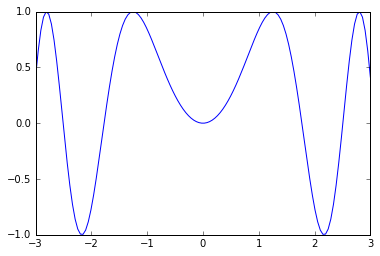

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void sin1d(float *x,float *y)
    {
      int idx = threadIdx.x + blockDim.x*blockIdx.x;
      y[idx] = sinf(powf(x[idx],2.0f));
    }
    """)

Nx = 128
x = np.linspace(-3,3,Nx).astype(np.float32)
y = np.empty_like(x)
func = mod.get_function("sin1d")
func(cuda.In(x),cuda.Out(y),block=(Nx,1,1),grid=(1,1,1))
plt.plot(x,y)

### Krok drugi

Nie będziemy teraz przesyłać wartości $x$ do jądra, ale obliczymy je w locie, ze wzoru:

$$ x = x_0 + i \frac{\Delta x}{N}$$

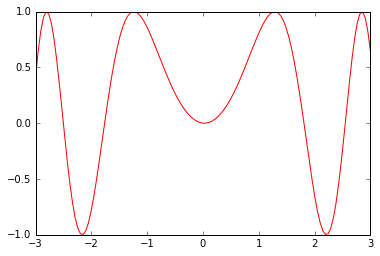

In [4]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void sin1da(float *y)
    {
      int idx = threadIdx.x + blockDim.x*blockIdx.x;
      float x = -3.0f+6.0f*float(idx)/blockDim.x;
      y[idx] = sinf(powf(x,2.0f));
    }
    """)

Nx = 128
x = np.linspace(-3,3,Nx).astype(np.float32)
y = np.empty_like(x)
func = mod.get_function("sin1da")
func(cuda.Out(y),block=(Nx,1,1),grid=(1,1,1))
plt.plot(x,y,'r')

### Krok trzeci

Wykonamy probkowanie funkcji dwóch zmiennych, korzystając z wywołania jądra, które zawiera $N_x$ wątków w bloku i $N_y$ bloków. 

Proszę zwrócić szczególną uwagę na linie:

    int idx = threadIdx.x;
    int idy = blockIdx.x;
    
zawierające wykorzystanie odpowiednich indeksów na CUDA, oraz sposób obliczania globalnego indeksu tablicy wartości, która jest w formacie "row-major"!

    int gid = idx + blockDim.x*idy;

In [5]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void sin2d(float *z)
    {
      int idx = threadIdx.x;
      int idy = blockIdx.x;

      int gid = idx + blockDim.x*idy;

      float x = -4.0f+6.0f*float(idx)/blockDim.x;
      float y = -3.0f+6.0f*float(idy)/gridDim.x;
      
      z[gid] = sinf(powf(x,2.0f)+powf(y,2.0f));
    }
    """)

Nx = 128
Ny = 64
x = np.linspace(-4,2,Nx).astype(np.float32)
y = np.linspace(-3,3,Ny).astype(np.float32)
XX,YY = np.meshgrid(x,y)
z = np.zeros(Nx*Ny).astype(np.float32)

func = mod.get_function("sin2d")
func(cuda.Out(z),block=(Nx,1,1),grid=(Ny,1,1))


Porównajmy wyniki:

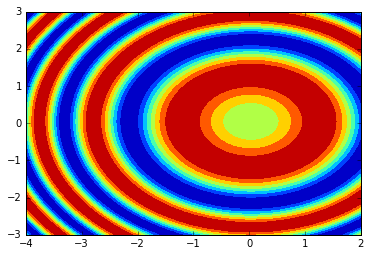

In [6]:
plt.contourf(XX,YY,z.reshape(Ny,Nx) )

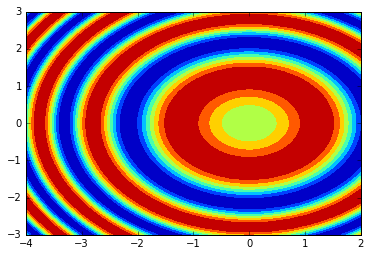

In [7]:
plt.contourf(XX,YY,np.sin(XX**2+YY**2))

### Krok czwarty

Algorytm ten nie jest korzystny, gdyż rozmiar bloku determinuje rozmiar siatki na, której próbkujemy funkcje. 

Optymalnie było by wykonywać operacje w blokach o zadanym rozmiarze, niezależnie od ilości próbek danego obszaru. 

Poniższy przykład wykorzystuje dwuwymiarową strukturę zarówno bloku jak i gridu. Dzielimy wątki tak by w obrębie jednego bloku były wewnatrz kwadratu o bokach 4x4.



In [8]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void sin2da(float *z)
    {
      int ix = threadIdx.x + blockIdx.x * blockDim.x;
      int iy = threadIdx.y + blockIdx.y * blockDim.y;
      
      int gid = ix + iy * blockDim.x * gridDim.x;
      float x = -4.0f+6.0f*float(ix)/(blockDim.x*gridDim.x);
      float y = -3.0f+6.0f*float(iy)/(blockDim.y*gridDim.y);
            
      z[gid] = sinf(powf(x,2.0f)+powf(y,2.0f));
    }
    """)

block_size = 4
Nx = 32*block_size
Ny = 32*block_size
x = np.linspace(-4,2,Nx).astype(np.float32)
y = np.linspace(-3,3,Ny).astype(np.float32)
XX,YY = np.meshgrid(x,y)
z = np.zeros(Nx*Ny).astype(np.float32)

func = mod.get_function("sin2da")
func(cuda.Out(z),\
     block=(block_size,block_size,1),\
     grid=(Nx/block_size,Ny/block_size,1)  )


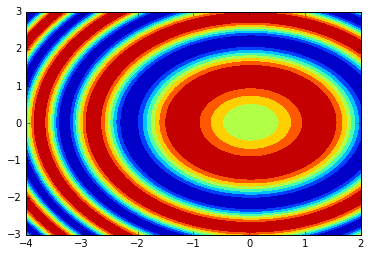

In [9]:
plt.contourf(XX,YY,z.reshape(Ny,Nx) )